In [2]:
import re
import time
import timeit

import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import ml
from sklearn.feature_extraction.text import CountVectorizer


In [3]:
cleaned_description = ml.get_and_clean_data()
cleaned_description = cleaned_description.apply(lambda s: re.sub(r'[^A-Za-z]', ' ', s))
cleaned_description = cleaned_description.apply(lambda s: re.sub(r'\s+', ' ', s))
tokenized_description = cleaned_description.apply(lambda s: word_tokenize(s))

concated = np.unique(np.concatenate([s for s in tokenized_description.values]))
stem_cache = {}
ps = PorterStemmer()
for s in concated:
    stem_cache[s] = ps.stem(s)

In [4]:
def setRemove(data):
    # print(len(data))
    tokenized_description = data 
    stop_set = set(stopwords.words())
    sw_removed_description = tokenized_description.apply(lambda s: set(s) - stop_set)
    sw_removed_description = sw_removed_description.apply(lambda s: {word for word in s if len(word) > 2})
    return sw_removed_description
    

In [5]:
size_list = [100, 500, 1000,2500,5000,7500,10000]
set_time = []


for size in size_list:
    set_time.append(timeit.timeit(lambda: setRemove(tokenized_description[:size]), number=1 ))
# set_time

In [6]:
array_time = []
matmul_time = []
todok_time = []
tolil_time = []
tocoo_time = []
tocsc_time = []

for size in size_list:
    sw_removed_data = setRemove(tokenized_description[:size])
    stemmed_description = sw_removed_data.apply(lambda s: [stem_cache[w] for w in s])
    cv = CountVectorizer(analyzer=lambda x: x)
    X = cv.fit_transform(stemmed_description)
    XX = X.toarray()
    array_time.append(timeit.timeit(lambda: X * X.T, number=1))
    matmul_time.append(timeit.timeit(lambda: np.matmul(XX, XX.T), number=1))
    todok_time.append(timeit.timeit(lambda: X.todok() * X.T.todok(), number=3) / 3)
    tolil_time.append(timeit.timeit(lambda: X.tolil() * X.T.tolil(), number=3) / 3)
    tocoo_time.append(timeit.timeit(lambda: X.tocoo() * X.T.tocoo(), number=3) / 3)
    tocsc_time.append(timeit.timeit(lambda: X.tocsc() * X.T.tocsc(), number=3) / 3)


    

In [7]:
df = pd.DataFrame({'size': size_list, 'array': array_time, 'matmul': matmul_time, 'dok': todok_time, 'lil': tolil_time, 'coo': tocoo_time, 'csc': tocsc_time  })
df

,size,array,matmul,dok,lil,coo,csc
0,100,0.008731,0.027966,0.038213,0.014872,0.001742,0.001409
1,500,0.025593,2.825684,0.175854,0.063455,0.025231,0.023556
2,1000,0.074676,16.539982,0.428570,0.168555,0.116318,0.102044
3,2500,0.618498,109.055450,0.900852,0.495049,0.440895,0.421598
4,5000,1.539361,358.559448,2.917356,1.942951,1.810812,1.799560
5,7500,3.908110,1164.092856,5.806040,4.297893,4.309656,4.754652
6,10000,4.663512,1116.768341,7.526363,4.695092,4.384400,4.731141


<Axes: title={'center': 'Benchmark Metric Multiplication'}, xlabel='size', ylabel='time(sec)'>

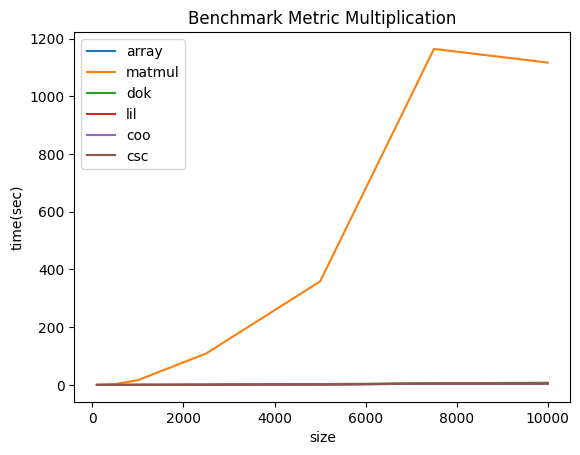

In [8]:
df.plot(x='size',y=['array','matmul','dok','lil','coo','csc'],ylabel='time(sec)', title='Benchmark Metric Multiplication')

<Axes: title={'center': 'Log-Log Plot'}, xlabel='size', ylabel='time(usec)'>

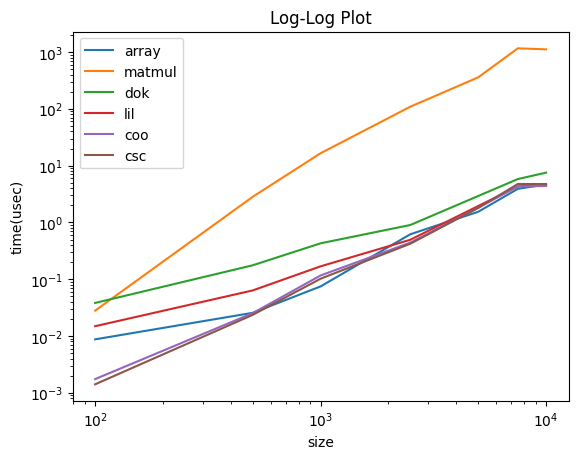

In [9]:
df.plot(x='size',y=['array','matmul','dok','lil','coo','csc'],ylabel='time(usec)',loglog=True, title='Log-Log Plot')